In [1]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from scipy.interpolate import Rbf
# import gstools as gs
# from matplotlib import cm

from metpy.units import units
from metpy.calc import wind_components, divergence, lat_lon_grid_deltas
from metpy.interpolate import interpolate_to_grid, remove_nan_observations
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import Rbf, RBFInterpolator
import gstools as gs
from matplotlib import cm

In [11]:
data_file = "../../../data/one_day_data/2020/07/2020-07-27/6-10.csv"
df = pd.read_csv(data_file, index_col=0)
df.head()
t = 'U-Wind'
t.upper()

'U-WIND'

In [3]:
def calc_u_v(df, ob_point):
    wind_dir = df['WD1']
    wind_speed = df['WS1']
    wind_u_v = wind_components(wind_speed * units('m/s'), wind_dir * units.deg)
    return [ob_point, round(wind_u_v[0].magnitude, 5), round(wind_u_v[1].magnitude, 5)] # (index, u wind, v wind) u: X (East-West) v: Y(North-South)
 
wind_df = pd.DataFrame([ calc_u_v(df.loc[i, :], i) for i in df.index ], columns=["OB-POINT", "U-WIND", "V-WIND"])
wind_df = wind_df.set_index('OB-POINT')
wind_df['LON'] = df['LON']
wind_df['LAT'] = df['LAT']
print(wind_df.dtypes)
wind_df.head()

U-WIND    float64
V-WIND    float64
LON       float64
LAT       float64
dtype: object


,U-WIND,V-WIND,LON,LAT
OB-POINT,,,,
Vlz-Bagbaguin_00174731,0.51962,0.30000,121.0009,14.7134
NagNayon_00181273,0.23511,0.32361,121.0285,14.7192
Sinegue_00181300,0.56382,0.20521,120.9319,14.4599
DLSAU_00174722,0.39945,-0.02093,120.9974,14.6705
ASTI_00173457,0.59553,-0.07312,121.0721,14.6471


------------------------------ linear ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


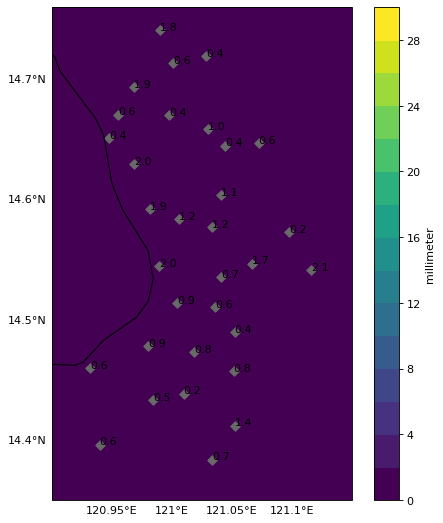

------------------------------ thin_plate_spline ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


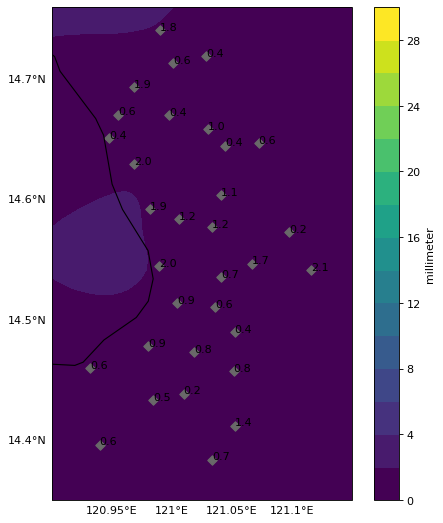

------------------------------ cubic ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


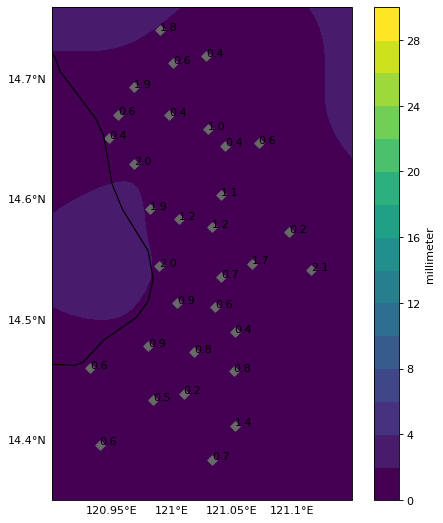

------------------------------ quintic ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


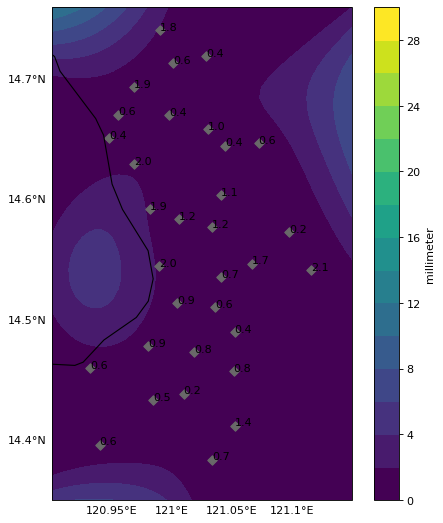

------------------------------ multiquadric ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


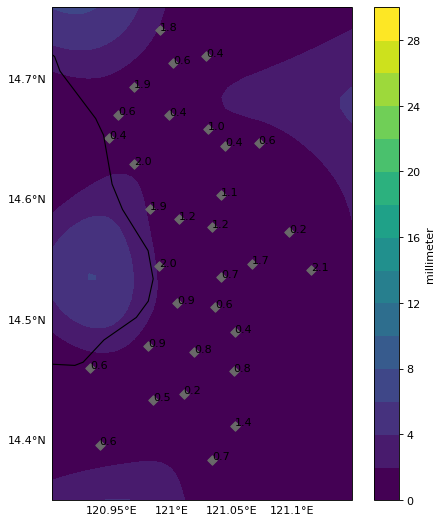

------------------------------ inverse_multiquadric ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


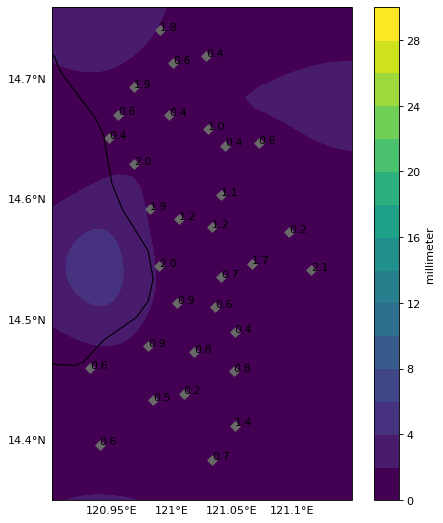

------------------------------ inverse_quadratic ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


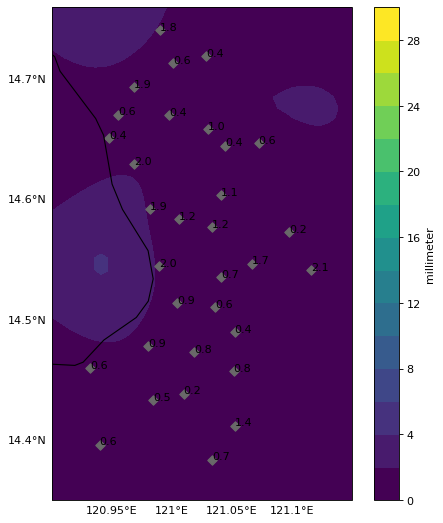

------------------------------ gaussian ------------------------------
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


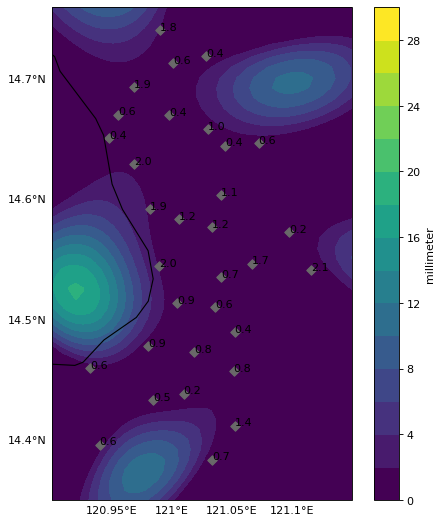

In [9]:
def rbf_test(kernel):
    print('-'*30, kernel, '-'*30)
    rbfi = RBFInterpolator(y=wind_df[['LON','LAT']],d=wind_df['U-WIND'], kernel=kernel, epsilon=10)
    grid_lon = np.round(np.linspace(120.90, 121.150, 50), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, 50), decimals=3)
    xi, yi = np.meshgrid(grid_lon, grid_lat)
    xgrid = np.around(np.mgrid[120.90:121.150:50j, 14.350:14.760:50j], decimals=3)
    xfloat = xgrid.reshape(2, -1).T
    
    xmi, ymi = xfloat[:, 0], xfloat[:, 1]
    
    z1 = rbfi(xfloat)
    z1 = z1.reshape(50, 50)
    rain_data = np.where(z1 > 0, z1, 0)
    rain_data = np.where(rain_data > 100, 100, rain_data)
    
    fig = plt.figure(figsize=(7, 8), dpi=80)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([120.90, 121.150, 14.350, 14.760])
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, alpha=0)
    gl.right_labels = False
    gl.top_labels = False

    clevs = list(range(0, 31, 2))
    print(clevs)
    cmap = cm.viridis
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(*xgrid, rain_data, clevs, cmap=cmap, norm=norm)
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('millimeter')
    ax.scatter(df['LON'], df['LAT'], marker='D', color='dimgrey')
    for i, val in enumerate(df['WS1']):
        ax.annotate(val, (df['LON'][i], df['LAT'][i]))
    plt.show()
    plt.close()
kernels = ['linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian']
for kernel in kernels:
    rbf_test(kernel)

------------------------------ gaussian ------------------------------
[14.76  14.746 14.732 14.718 14.703 14.689 14.675 14.661 14.647 14.633
 14.619 14.604 14.59  14.576 14.562 14.548 14.534 14.52  14.506 14.491
 14.477 14.463 14.449 14.435 14.421 14.407 14.392 14.378 14.364 14.35 ]
6.056550753076934 -7.094126957327851


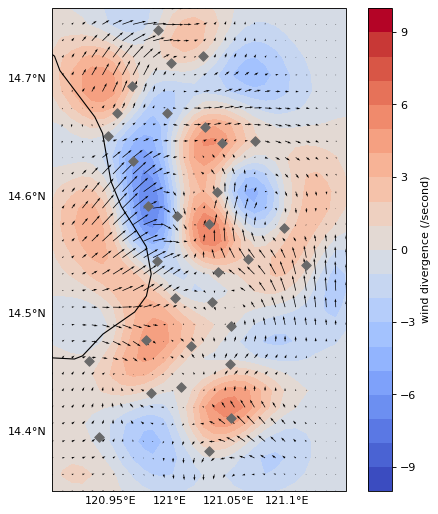

In [8]:
def rbf_test(func):
    grid_size = 30
    print('-'*30, func, '-'*30)
    v_wind_rbfi = Rbf(wind_df['LON'], wind_df['LAT'], wind_df['V-WIND'].values, function=func)
    u_wind_rbfi = Rbf(wind_df['LON'], wind_df['LAT'], wind_df['U-WIND'].values, function=func)
    grid_lon = np.round(np.linspace(120.90, 121.150, grid_size), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, grid_size), decimals=3)
    xi, yi = np.meshgrid(grid_lon, grid_lat)
    v_wind = v_wind_rbfi(xi, yi)
    u_wind = u_wind_rbfi(xi, yi)
    v_wind = np.where(v_wind > 20, 20, v_wind)
    v_wind = np.where(v_wind < -20, -20, v_wind)
    u_wind = np.where(u_wind > 20, 20, u_wind)
    u_wind = np.where(u_wind < -20, -20, u_wind)
    
    v_wind_grad = np.array(np.gradient(v_wind)[1])
    u_wind_grad = np.array(np.gradient(u_wind)[0])
    wind_div = np.empty([grid_size, grid_size])
    for i in range(grid_size):
        for j in range(grid_size):
            x_left = i - 1 if i - 1 > 0 else 0
            x_right = i + 1 if i + 1 < grid_size - 1 else grid_size - 1
            y_above = j + 1 if j + 1 < grid_size - 1 else grid_size - 1
            y_bottom = j - 1 if j - 1 > 0 else 0
            val = 0
            for x in range(x_left, x_right + 1):
                for y in range(y_bottom, y_above + 1):
                    val += v_wind_grad[x, y] + u_wind_grad[x, y]
            wind_div[i, j] = val
    #wind_div = v_wind_grad + u_wind_grad
    wind_div = np.where(wind_div > 10, 10, wind_div)
    wind_div = np.where(wind_div < -10, -10, wind_div)
    
    # Create DataFrame
    wind_div_df = pd.DataFrame(wind_div, index=grid_lat, columns=grid_lon)
    print(np.flip(grid_lat))
    print(wind_div.max(), wind_div.min())
    fig = plt.figure(figsize=(7, 8), dpi=80)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([120.90, 121.150, 14.350, 14.760])
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, alpha=0)
    gl.right_labels = False
    gl.top_labels = False
    
    #clevs = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
    clevs = list(range(-10, 11))
    cmap = cm.coolwarm
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(xi, yi, wind_div, clevs, cmap=cmap, norm=norm)
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('wind divergence (/second)')
    plt.quiver(xi, yi, u_wind, v_wind)
    ax.scatter(df['LON'], df['LAT'], marker='D', color='dimgrey')
    plt.show()
    plt.close()
    return wind_div_df
func_names = ['gaussian']#['multiquadric', 'inverse', 'gaussian', 'linear', 'cubic', 'quintic', 'thin_plate']
for func in func_names:
    test_df = rbf_test(func)

In [5]:
test_df.head()

,120.900,120.909,120.917,120.926,120.934,120.943,120.952,120.960,120.969,120.978,...,121.072,121.081,121.090,121.098,121.107,121.116,121.124,121.133,121.141,121.150
14.350,0.434328,0.714093,0.819339,0.855112,0.790065,0.605481,0.314797,-0.061854,-0.448010,-0.793886,...,-1.109135,-1.117654,-1.034071,-0.883719,-0.689524,-0.489522,-0.320748,-0.197747,-0.114480,-0.053899
14.364,0.637901,1.035089,1.154781,1.161093,0.999726,0.644601,0.120599,-0.531982,-1.176447,-1.724618,...,-1.920681,-2.004357,-1.897073,-1.646045,-1.300071,-0.933338,-0.614423,-0.380099,-0.223492,-0.106093
14.378,0.557889,0.874524,0.902015,0.808515,0.528143,0.039955,-0.624848,-1.408346,-2.135166,-2.691806,...,-1.845576,-2.166657,-2.201632,-2.002082,-1.635763,-1.207299,-0.807004,-0.504874,-0.305289,-0.147105
14.392,0.401656,0.589163,0.511720,0.331194,-0.021942,-0.564729,-1.270316,-2.076543,-2.789344,-3.275882,...,-0.617487,-1.332097,-1.700363,-1.748979,-1.542142,-1.202569,-0.830204,-0.531565,-0.334994,-0.164957
14.407,0.266811,0.356437,0.233654,0.058304,-0.225387,-0.638861,-1.182920,-1.831251,-2.425436,-2.835791,...,1.730008,0.598544,-0.224158,-0.701412,-0.852087,-0.787199,-0.594661,-0.404295,-0.276822,-0.142079


In [26]:
a = [1, 2, 3, 4, 5]
ans = ''
for i in a[::-1][:-1]:
    ans += str(i) + ' '
print(ans + '1')

5 4 3 2 1


In [20]:
n /= 10
n

3.1